In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
from scipy.io import loadmat
from datetime import datetime, timedelta
sys.path.append('/home/manu/TFG_repo/scripts')

In [3]:
from analysis_routines import *
from config import data_dir, reports_dir
from plotting_routines_xr import *
from processing_routines import datenum_to_epoch
from wavelet_analysis import wavelet_power_spectrum
from harmonic_analysis import *
from scipy.stats import chi2
from statsmodels.tsa.stattools import acf, adfuller, ccf, ccovf
plt.style.use('/home/manu/TFG_repo/notebooks/mplstyles/report.mplstyle')

In [4]:
data_chain = load_time_series_xr('processed/AGL_20181116_chain_xrcompatible.nc')
fit_chain = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_fci.csv')
data_buoy = load_buoy_series('AGL_ocean_meteo_20181116.nc')

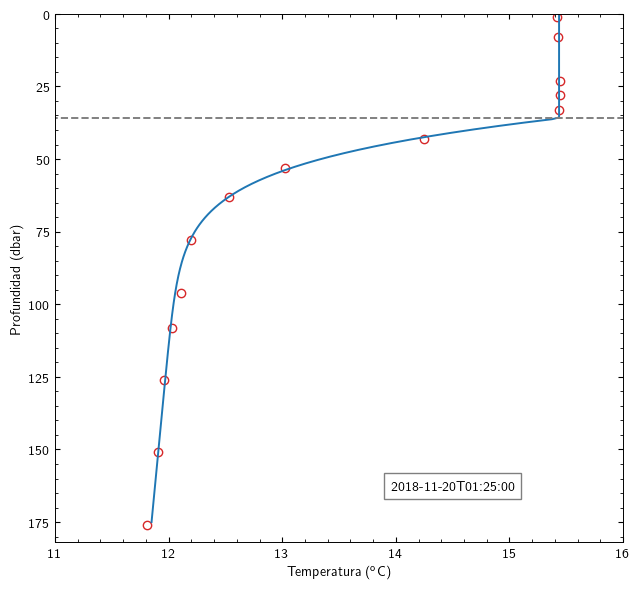

In [16]:
slice_ = slice(datetime(2018, 11, 19, 18, 0), datetime(2018, 11, 20, 1, 25), 5)
chain_period = data_chain.sel(date=slice_)
animate_profile_evolution(fit_chain, data_chain, 'soliton_presentacion_radiales.mp4', 
                          period=[datetime(2018, 11, 19, 18, 0), datetime(2018, 11, 20, 1, 25)], 
                          num_plots=600)

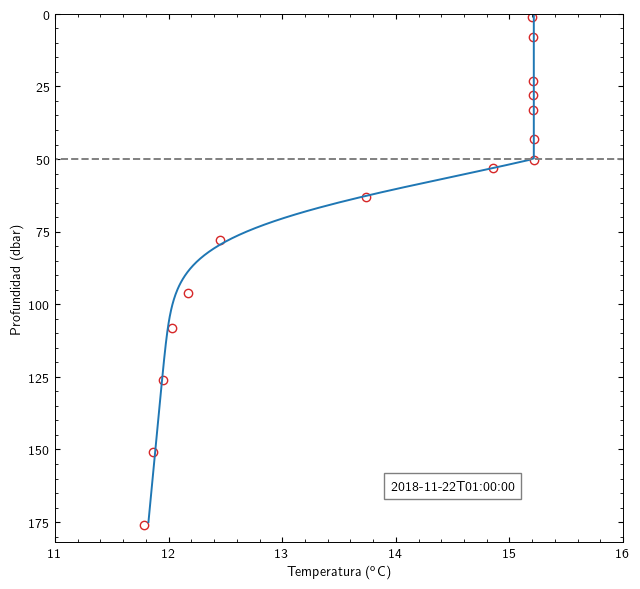

In [15]:
animate_profile_evolution(fit_chain, data_chain, 'marea_interna_presentacion_radiales.mp4', 
                          period=[datetime(2018, 11, 20, 22, 30), datetime(2018, 11, 22, 1), 5], 
                          num_plots=600)

In [ ]:
plot_column_temperature(data_chain, fit_chain, period=[datetime(2018, 11, 20, 3), datetime(2018, 11, 22, 1), 120], ylims=[120, 0])

In [16]:
date_7 = datetime(2018, 11, 21, 8)
date_8 = datetime(2018, 11, 21, 16)
period_s1 = [date_7, date_8]

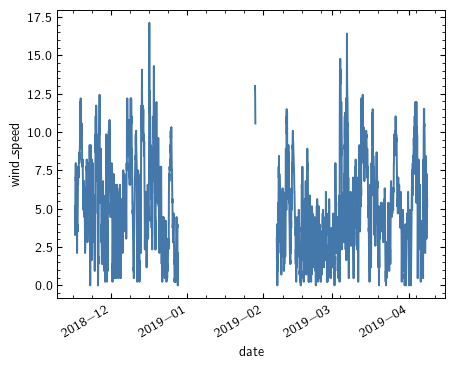

In [15]:
data_buoy.wind_speed.plot()

In [25]:

coriolis_frequency = 2*7.2921e-5*np.sin(np.deg2rad(data_chain.lat.data)[0])
coriolis_freq_cps = coriolis_frequency/2/np.pi
coriolis_freq_cpd = coriolis_freq_cps*60*60*24
M2_cpd = 1/12.42061*24
M6_cpd = 1/4.14020*24
M4_cpd = 1/6.210301*24
K1_cpd = 1/23.934470*24
Q1_cpd = 1/28.006223*24
M3_cpd = 1/8.280401*24
M8_cpd = 1/3.105150*24
O1_cpd = 1/1/25.819351*24 # not present in temperature record
Q1_2_cpd = 1/28.006223*24

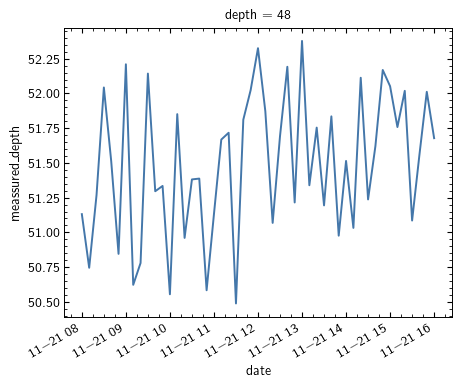

In [18]:
data_chain.meassured_depth[::120].sel(depth=48, date=slice(*period_s1)).plot()

In [41]:
freqs_depth48, psd_depth48, dof_depth48 = windowed_spectrum(
    data_chain.meassured_depth[::120].sel(depth=201).data, 5*120/60/60/24, 28, 3)

In [55]:
depths_201 = data_chain.meassured_depth[::60].sel(depth=201)
depths_48 = data_chain.meassured_depth[::120].sel(depth=48)

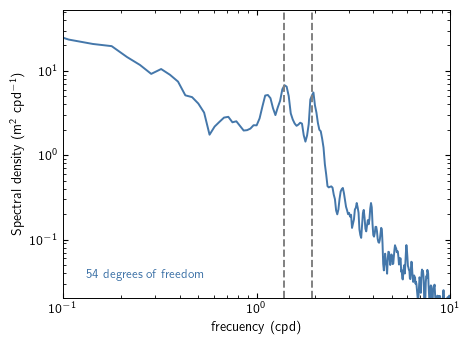

In [42]:
plot_spectrum(freqs_depth48, psd_depth48, dof_depth48, 'cpd', 'm', vlines=[coriolis_freq_cpd, M2_cpd], 
              xlim=(10**-1, 10**1), ylim=(2*10**-2, None))

In [69]:
from wavelet_classes import Wavelet
a = Wavelet(depths_201, data_chain.date[::60], [datetime(2019, 1, 15), datetime(2019, 2, 10)])
a.compute()

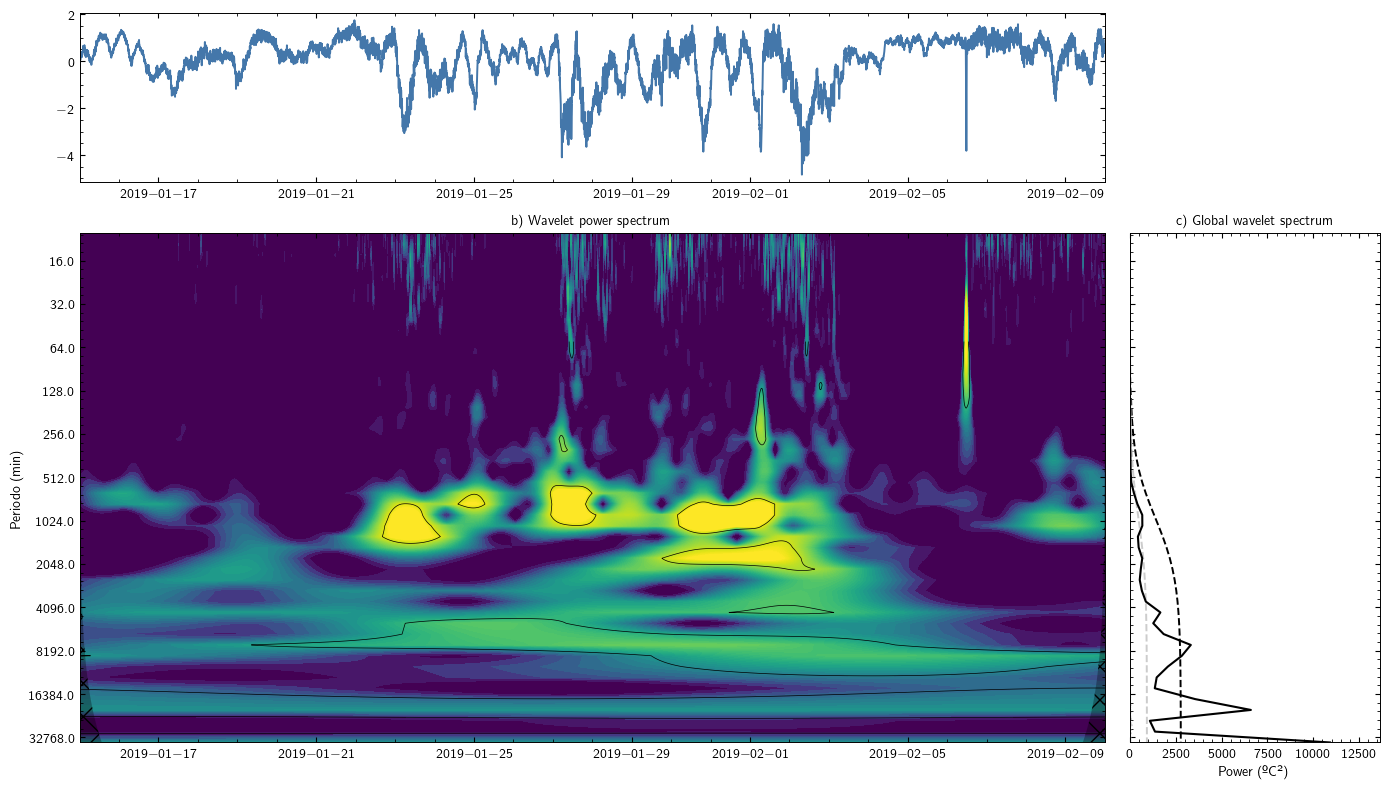

In [70]:
a.complete_plot(norm_levels=2**12)

In [5]:
def dummy_thermocline(x, a1, mld, k):
    pos = np.where(x >= mld, 1.0, 0.0)    
    # chech if exponent is inside limits

    return a1 + pos * 3*( np.exp(-k * (x - mld)) -1  -0.002442*(x - mld))


In [6]:
xx = np.arange(0, 176, 0.5)
x = np.array([  1,   8,  23,  28,  33,  43,  48,  53,  63,  78,  96, 108, 126, 151,
       176, 201])

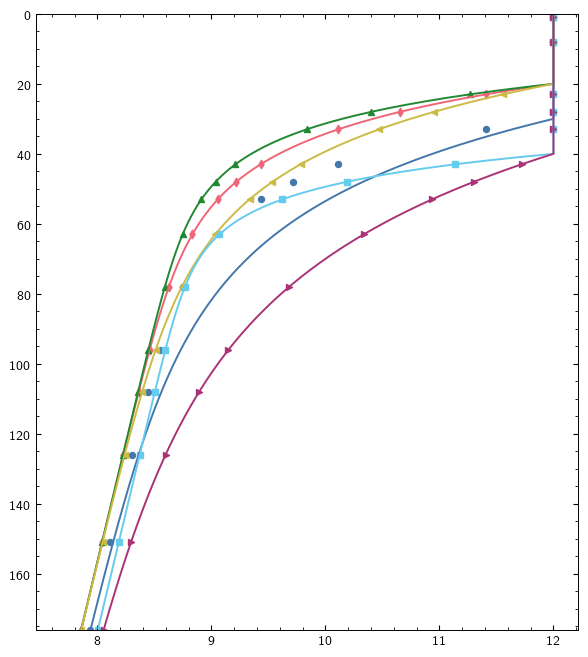

In [7]:
fig, ax = plt.subplots(figsize=(7, 8))
ax.plot(dummy_thermocline(xx, 12, 30, 0.04), xx)
ax.plot(dummy_thermocline(xx, 12, 20, 0.07), xx)
ax.plot(dummy_thermocline(xx, 12, 20, 0.07+0.02), xx)
ax.plot(dummy_thermocline(xx, 12, 20, 0.07-0.02), xx)
ax.plot(dummy_thermocline(xx, 12, 40, 0.07+0.04), xx)
ax.plot(dummy_thermocline(xx, 12, 40, 0.07-0.04), xx)


ax.scatter(dummy_thermocline(x, 12, 30, 0.07), x)
ax.scatter(dummy_thermocline(x, 12, 20, 0.07), x, marker='d')
ax.scatter(dummy_thermocline(x, 12, 20, 0.07+0.02), x, marker='^')
ax.scatter(dummy_thermocline(x, 12, 20, 0.07-0.02), x, marker='<')
ax.scatter(dummy_thermocline(x, 12, 40, 0.07+0.04), x, marker='s')
ax.scatter(dummy_thermocline(x, 12, 40, 0.07-0.04), x, marker='>')


ax.set_ylim(176, 0)

plt.show()

(200.0, 0.0)

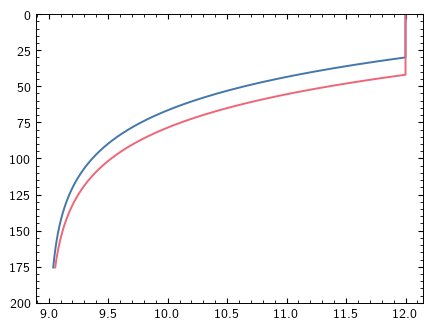

In [99]:
low = dummy_thermocline(xx, 12, 30, 0.03)
high = np.zeros_like(low)
high[24:] = low[:-24]
high[:25] = low[0]
plt.plot(low, xx)
plt.plot(high, xx)
plt.ylim(200, 0)

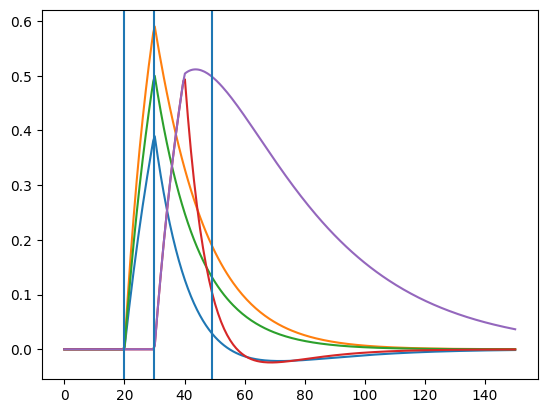

In [166]:
fig, ax = plt.subplots()
ax.plot(xx, dummy_thermocline(xx, 12, 30, 0.07) - dummy_thermocline(xx, 12, 20, 0.07-0.02))
ax.plot(xx, dummy_thermocline(xx, 12, 30, 0.07) - dummy_thermocline(xx, 12, 20, 0.07+0.02))
ax.plot(xx, dummy_thermocline(xx, 12, 30, 0.07) - dummy_thermocline(xx, 12, 20, 0.07))


ax.plot(xx, - dummy_thermocline(xx, 12, 30, 0.07) + dummy_thermocline(xx, 12, 40, 0.07+0.04))
ax.plot(xx, - dummy_thermocline(xx, 12, 30, 0.07) + dummy_thermocline(xx, 12, 40, 0.07-0.04))
ax.axvline(20)
ax.axvline(30)
ax.axvline(49)

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5, 6))
ax.plot(dummy_thermocline(xx, 12, 30, 0.07), xx)
ax.plot(dummy_thermocline(xx, 12, 20, 0.07), xx)
ax.plot(dummy_thermocline(xx, 12, 20, 0.07+0.02), xx)
ax.plot(dummy_thermocline(xx, 12, 20, 0.07-0.01), xx)
ax.scatter(dummy_thermocline(x, 12, 30, 0.07), x)
ax.scatter(dummy_thermocline(x, 12, 20, 0.07), x)
ax.scatter(dummy_thermocline(x, 12, 20, 0.07+0.02), x)
ax.scatter(dummy_thermocline(x, 12, 20, 0.07-0.01), x)
ax.set_ylim(176, 0)

plt.show()

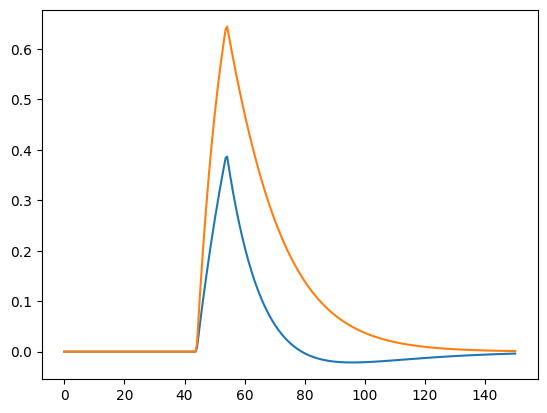

In [124]:
fig, ax = plt.subplots()
ax.plot(xx, dummy_thermocline(xx, 12, 54, 0.07) - dummy_thermocline(xx, 12, 44, 0.06-0.01))
ax.plot(xx, dummy_thermocline(xx, 12, 54, 0.07) - dummy_thermocline(xx, 12, 44, 0.065+0.04))
plt.show()

In [11]:
test = load_SHDR_fit('SHDR_trials/pres-1.csv')
temp, depth, date = load_time_series('test/test_spring_short.nc')

In [18]:
test_series = load_time_series_xr('processed/AGL_20181116_chain_xrcompatible.nc')

In [24]:
test_series = test_series.sel(date=slice(date[0], date[-1]))

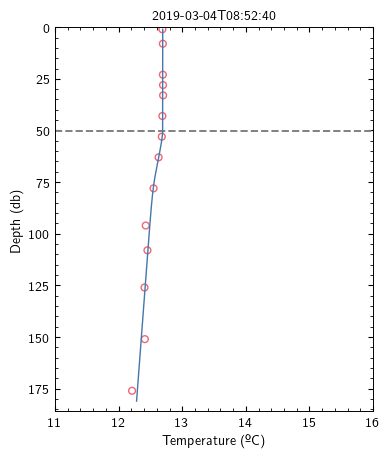

In [30]:
plot_profile_fit(test, test_series, 3500)

In [34]:
np.log(2)

0.6931471805599453

In [33]:
np.exp(-2) - np.exp(-3)

0.08554821486874875

In [37]:
np.log(0.02/0.04)/(0.02-0.04)

34.657359027997266

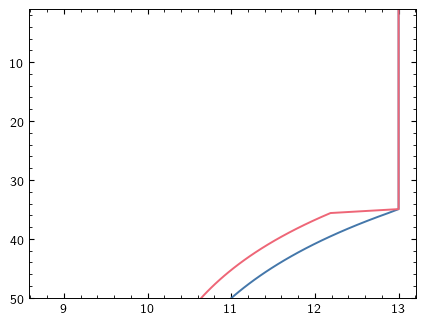

In [104]:
zz = np.linspace(1, 200, 300)
fig, ax = plt.subplots()
ax.plot(dummy_thermocline(zz, 13, 35, 0.066), zz)
ax.plot((dummy_thermocline(zz, 13, 35, 0.066) - dummy_oscilation(zz, 35, 0.71, 0.045)), zz)

ax.set_ylim(50, 1)
plt.show()

In [91]:
def dummy_oscilation(x, mld, a, k):
    pos = np.where(x >= mld, 1.0, 0.0)    
    return pos*a*(np.exp(-k * (x - mld)))


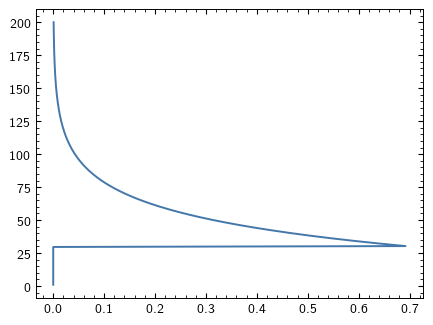

In [100]:
plt.plot(dummy_oscilation(zz, 30, 0.7, 0.04), zz)

In [7]:
def exp_(zz, a, k):
    return a*np.exp(zz* - k)

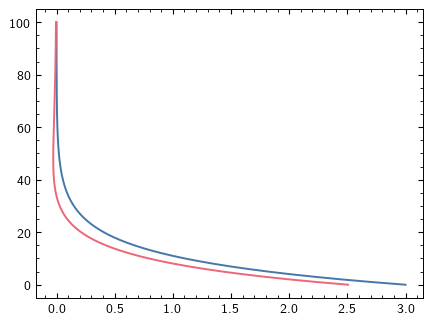

In [15]:
zz = np.linspace(0, 100, 300)
zz_2 = np.linspace(7, 100, 300)
plt.plot(exp_(zz, 3, 0.1), zz)
plt.plot(exp_(zz, 3, 0.1) - exp_(zz_2, 0.7, 0.05), zz)